In [853]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import pdb
import numpy as np

# Caricamento dati e left join e arricchimento con Regione
Carico i dati dei customers, e il file Excel con Regione-Provincia-CAP. Trasformo in stringa alcune colonne, e faccio una left join tra Ottobre e Province.
Adesso ho un dataframe iniziale, ma arricchito con la REGIONE del cliente

In [1162]:
#Prende File che contiene Provincia-cap-provAbbreviata
prov=pd.read_csv('comune_cap_pr_regione.csv',sep=';')
df = gpd.read_file('Italy_Regions.json')
#Carico il file con le province
prov['REGIONE']=prov['REGIONE'].str.upper()
#Carico il file di Ottobre
Ottobre=pd.read_csv('Ottobre.csv',sep='\t',low_memory=False)

Ottobre['CAP1']=Ottobre['CAP1'].astype(str)
prov['CAP1']=prov['CAP1'].astype(str)
Ottobre['CAP1']=Ottobre['CAP1'].str.split('.')
Ottobre['CAP1']=Ottobre['CAP1'].apply(lambda x: x[0])
Ottobre['COMUNE']=Ottobre['COMUNE'].astype(str)
prov['COMUNE']=prov['COMUNE'].astype(str)
#Nome del comune in LowerCase per fare il join left
prov['COMUNE']=prov['COMUNE'].str.lower()
Ottobre['COMUNE']=Ottobre['COMUNE'].str.lower()
#Join left
result = pd.merge(Ottobre, prov, on='COMUNE', how='left') #Una merge per aggiungere la regione del customer
Ottobre=result
Ottobre=Ottobre[['Progressivo_Follow_Up','User_ID','COMUNE','Genere','Data_di_nascita','Fonte_acquisto','Utente_Convertito',
        'Tipo_di_Utilizzo','REGIONE','CAP1_x','Risultato_contatto_Whatsapp']]
#Ottobre.rename(columns={'CAP1_x':'CAP'}, inplace=True)


23

Adesso ho un problema: uno stesso utente posso ritrovarlo in vari step (sempre lo stesso customer può essere in step 1,2,3,4). Allora, conto quante volte ogni utente è ripetuto nel dataframe, in modo che io sappia quanti step ha eseguito ogni utente

In [855]:
Ottobre_Num_Step=Ottobre.groupby(['User_ID']).count()

In [869]:
#Remap di Tipo_di_Utilizzo
risposte={'Mai':0,'Occasionale/Duale':1,'Prevalente':2,'Esclusivo':3}
Ottobre=Ottobre.copy()
Ottobre['Tipo_di_Utilizzo']=Ottobre['Tipo_di_Utilizzo'].map(risposte)
risposte_conv={'SI':1,'NO':0}
Ottobre['Utente_Convertito']=Ottobre['Utente_Convertito'].map(risposte_conv)
risposte_interaction={'Ha visualizzato e interagito':1,'Ha visualizzato ma non ha interagito':0,'Non ha visualizzato':0}
Ottobre['Risultato_contatto_Whatsapp']=Ottobre['Risultato_contatto_Whatsapp'].map(risposte_interaction)

Calcolo dell'età di ogni customer

In [870]:
#Calcolo dell età del customer
def Data(x):
    x=str(x).split()[0].split('/')[-1]
    if len(x)<4:
        x='19'+x
    try:
        x=2017-int(x)
    except:
        return(np.nan)
    return(int(x))

Ottobre['Eta']=Ottobre['Data_di_nascita'].apply(Data)

In [858]:
Ottobre

,Progressivo_Follow_Up,User_ID,COMUNE,Genere,Data_di_nascita,Fonte_acquisto,Utente_Convertito,Tipo_di_Utilizzo,REGIONE,CAP1_x,Risultato_contatto_Whatsapp,Eta
0,3,295199,verona,M,5/17/1992 12:00:00 AM,IQOS STORE,NaN,NaN,VENETO,37123,0.0,25.0
1,2,302334,roma,M,08/09/84 00:00,ALTRO,1.0,3.0,LAZIO,148,1.0,33.0
2,2,302273,san giorgio a cremano,F,04/09/95 00:00,IQOS STORE,1.0,3.0,CAMPANIA,80046,1.0,22.0
3,2,302840,parabiago,F,04/08/70 00:00,IQOS STORE,1.0,3.0,LOMBARDIA,20015,1.0,47.0
4,3,295144,siracusa,F,08/09/88 00:00,IQOS STORE,NaN,NaN,SICILIA,96100,0.0,29.0
5,3,297187,roma,F,1/18/1955 12:00:00 AM,ALTRO,1.0,2.0,LAZIO,197,1.0,62.0
6,2,311564,albinea,F,09/11/67 00:00,IQOS STORE,NaN,2.0,EMILIA-ROMAGNA,42020,1.0,50.0
7,2,311843,budrio,M,1/21/1990 12:00:00 AM,IQOS STORE,NaN,2.0,EMILIA-ROMAGNA,40054,1.0,27.0
8,2,310433,pralboino,F,12/12/87 00:00,IQOS STORE,0.0,1.0,LOMBARDIA,25020,1.0,30.0
9,2,311890,santa marinella,F,11/21/1970 12:00:00 AM,IQOS STORE,NaN,2.0,LAZIO,58,1.0,47.0


In [871]:
#Max valori di Progressivo_Follow_Up,Tipo_di_Utilizzo,Utente_Convertito - che 
#con la mappatura di prima sono valori numerici

j=Ottobre.groupby(['User_ID'])['Tipo_di_Utilizzo','Utente_Convertito','Progressivo_Follow_Up','Risultato_contatto_Whatsapp'].max().reset_index()


In [872]:
#Dati anagrafici di ogni customer e left join
Dati_Anagrafici=Ottobre.copy()
Dati_Anagrafici=Ottobre.loc[:,['User_ID','Genere','COMUNE','Eta','REGIONE','Fonte_acquisto','CAP1_x']]
result=pd.merge(Dati_Anagrafici,j,on='User_ID',how='left')
result

,User_ID,Genere,COMUNE,Eta,REGIONE,Fonte_acquisto,CAP1_x,Tipo_di_Utilizzo,Utente_Convertito,Progressivo_Follow_Up,Risultato_contatto_Whatsapp
0,295199,M,verona,25.0,VENETO,IQOS STORE,37123,NaN,NaN,3,0.0
1,302334,M,roma,33.0,LAZIO,ALTRO,148,3.0,1.0,2,1.0
2,302273,F,san giorgio a cremano,22.0,CAMPANIA,IQOS STORE,80046,3.0,1.0,2,1.0
3,302840,F,parabiago,47.0,LOMBARDIA,IQOS STORE,20015,3.0,1.0,2,1.0
4,295144,F,siracusa,29.0,SICILIA,IQOS STORE,96100,NaN,NaN,3,0.0
5,297187,F,roma,62.0,LAZIO,ALTRO,197,2.0,1.0,3,1.0
6,311564,F,albinea,50.0,EMILIA-ROMAGNA,IQOS STORE,42020,3.0,1.0,3,1.0
7,311843,M,budrio,27.0,EMILIA-ROMAGNA,IQOS STORE,40054,3.0,1.0,3,1.0
8,310433,F,pralboino,30.0,LOMBARDIA,IQOS STORE,25020,1.0,0.0,3,1.0
9,311890,F,santa marinella,47.0,LAZIO,IQOS STORE,58,3.0,1.0,3,1.0


# Mappa 1: numero di utenti per ogni regione italiana

In [873]:
Num_Users=result.groupby('REGIONE')[['User_ID']].count()
Num_Users.reset_index()

,REGIONE,User_ID
0,ABRUZZO,348
1,BASILICATA,85
2,CALABRIA,284
3,CAMPANIA,1241
4,EMILIA-ROMAGNA,2182
5,FRIULI-VENEZIA GIULIA,82
6,LAZIO,2045
7,LIGURIA,156
8,LOMBARDIA,1998
9,MARCHE,317


In [944]:
df2=df.copy()
df2.set_value(3, 'name', 'trentino-alto adige')
df2.set_value(5, 'name', 'friuli-venezia giulia')
df2['name']=df2['name'].str.upper()
df2 = df2.rename(columns={'name': 'REGIONE'})
Num_Users=Num_Users.reset_index()
df2=pd.merge(df2,Num_Users,on='REGIONE',how='left')
df2 = df2.rename(columns={'User_ID': 'Count_Users'})

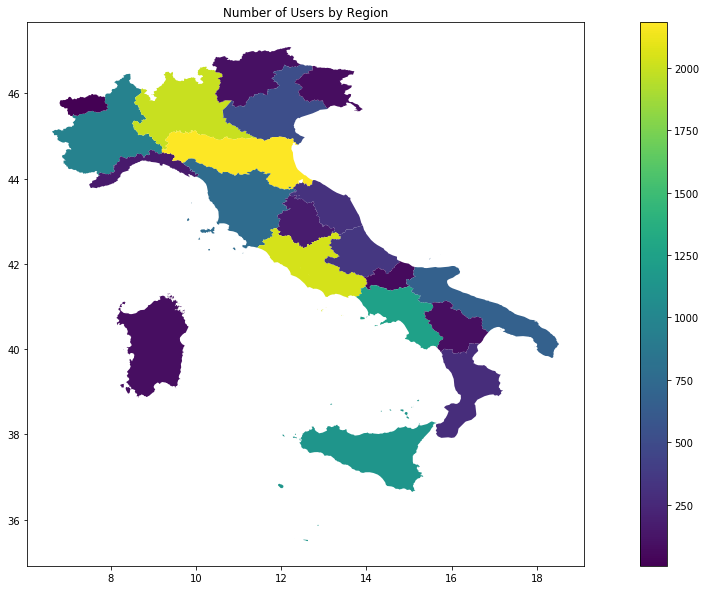

In [970]:
df2.plot(column='Count_Users',legend=True, alpha=1)
plt.title('Number of Users by Region')
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(20, 10)
fig.savefig('Numer_of_Users_by_Region.png', dpi=200)
plt.show()

# Mappa 2: % di maschi per regione

In [876]:
Num_Genere=result.groupby(['REGIONE','Genere'])['User_ID'].count()
Num_Genere=Num_Genere.reset_index()
L=[]
for el in range(0,len(Num_Genere['User_ID']),2):
    Somma=Num_Genere['User_ID'][el]+Num_Genere['User_ID'][el+1]
    L.append(Somma)
    L.append(Somma)

Num_Genere['Somma']=L
Num_Genere['Ratio']=(Num_Genere['User_ID']/Num_Genere['Somma'])*100
Num_Genere

,REGIONE,Genere,User_ID,Somma,Ratio
0,ABRUZZO,F,101,346,29.190751
1,ABRUZZO,M,245,346,70.809249
2,BASILICATA,F,21,85,24.705882
3,BASILICATA,M,64,85,75.294118
4,CALABRIA,F,71,284,25.000000
5,CALABRIA,M,213,284,75.000000
6,CAMPANIA,F,356,1222,29.132570
7,CAMPANIA,M,866,1222,70.867430
8,EMILIA-ROMAGNA,F,873,2178,40.082645
9,EMILIA-ROMAGNA,M,1305,2178,59.917355


In [879]:
Num_Genere=result.groupby(['REGIONE','Genere'])['User_ID'].count()


REGIONE                Genere
ABRUZZO                F          101
                       M          245
BASILICATA             F           21
                       M           64
CALABRIA               F           71
                       M          213
CAMPANIA               F          356
                       M          866
EMILIA-ROMAGNA         F          873
                       M         1305
FRIULI-VENEZIA GIULIA  F           27
                       M           55
LAZIO                  F          894
                       M         1143
LIGURIA                F           52
                       M          104
LOMBARDIA              F          747
                       M         1242
MARCHE                 F          111
                       M          201
MOLISE                 F           18
                       M           44
PIEMONTE               F          349
                       M          607
PUGLIA                 F          192
                    

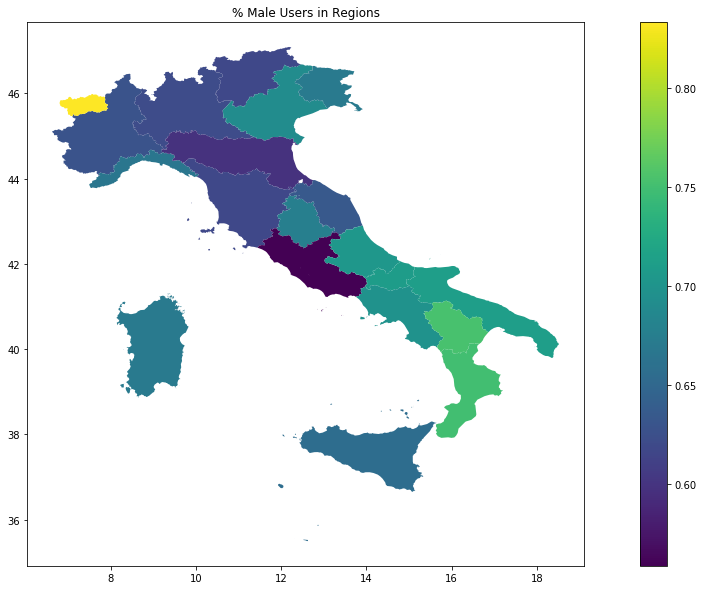

In [971]:
Num_Genere2=Num_Genere.copy()
Num_Genere2=Num_Genere2.reset_index()
Num_Genere_M=Num_Genere2[Num_Genere2['Genere']=='M']
#df2 = df2.rename(columns={'name': 'REGIONE'})

Result_M=pd.merge(df2,Num_Genere_M,how='left',on='REGIONE')
Result_M['Ratio']=Result_M['User_ID']/Result_M['Count_Users']

Result_M.plot(column='Ratio',legend=True, alpha=1)
plt.title('% Male Users in Regions')
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(20, 10)
fig.savefig('Perc_Males in Region.png', dpi=200)
plt.show()

# Mappa 3: Numero di utenti totale su superficie

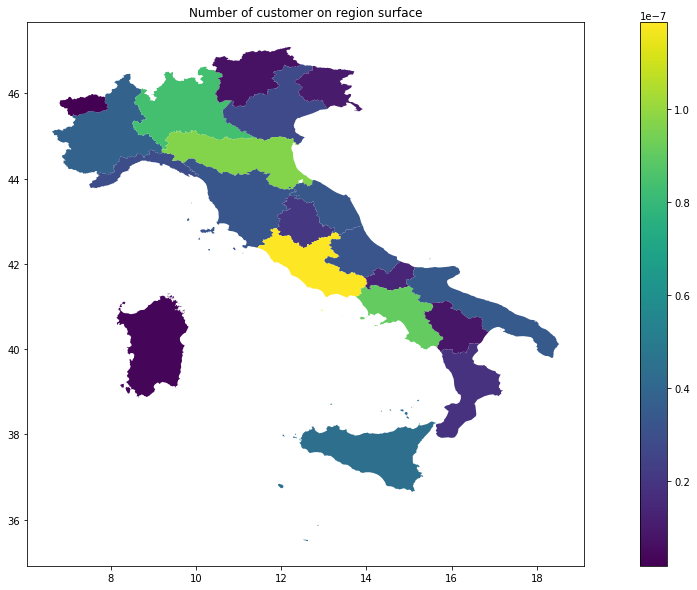

In [972]:
df2['Ratio_on_Area']=df2['Count_Users']/df2['area']
df2.plot(column='Ratio_on_Area',legend=True, alpha=1)

plt.title('Number of customer on region surface')
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(20, 10)
fig.savefig('Users_on_surface.png', dpi=200)
plt.show()


# Mappa 4: età media in ogni regione

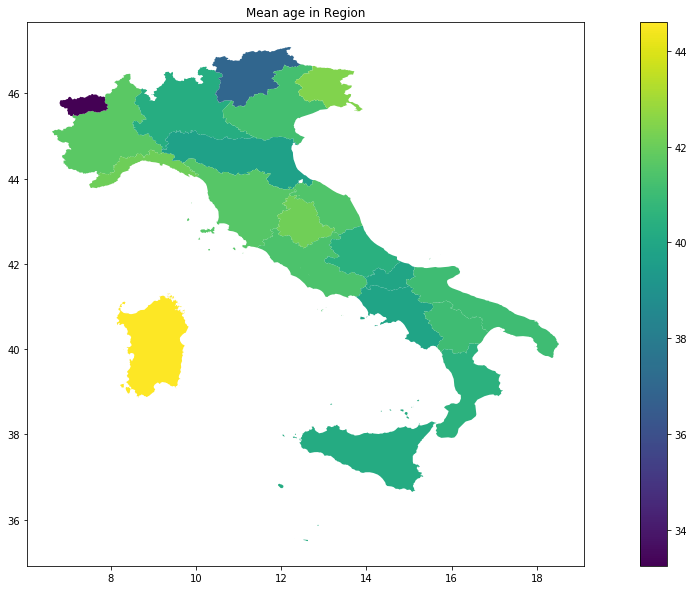

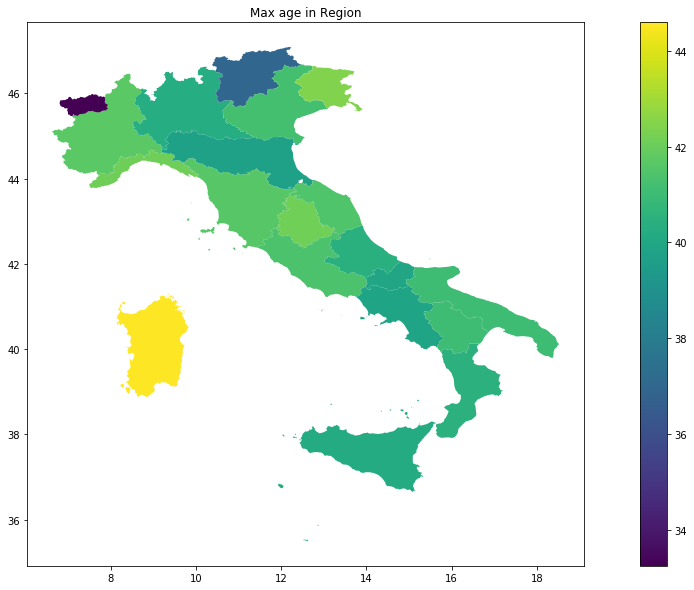

In [990]:
#result contiene i dati degli utenti, interazione, uso esclusivo, progressivo_follow_up e REGIONE e altro
#R_tot=result.groupby(['REGIONE','User_ID'])[['User_ID']].count()
#R=result[result['Risultato_contatto_Whatsapp']==1]
#R=R.groupby(['REGIONE'])['Risultato_contatto_Whatsapp'].count()
R=result[(result['Eta']>18) & (result['Eta']<100)].copy()
R2=R.copy()
R2=R2[['User_ID','REGIONE','Eta']]
R2.drop_duplicates(keep='first', inplace=True)

R2=R2.groupby(['REGIONE'])[['Eta']].mean()

#Plot
R2=R2.reset_index()
Eta=pd.merge(df2,R2,how='left',on='REGIONE')
Eta.plot(column='Eta',legend=True)
plt.title('Mean age in Region')
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(20, 10)
fig.savefig('Mean_Age_In_Regions.png', dpi=200)
plt.show()



# Mappa massima età per ogni regione

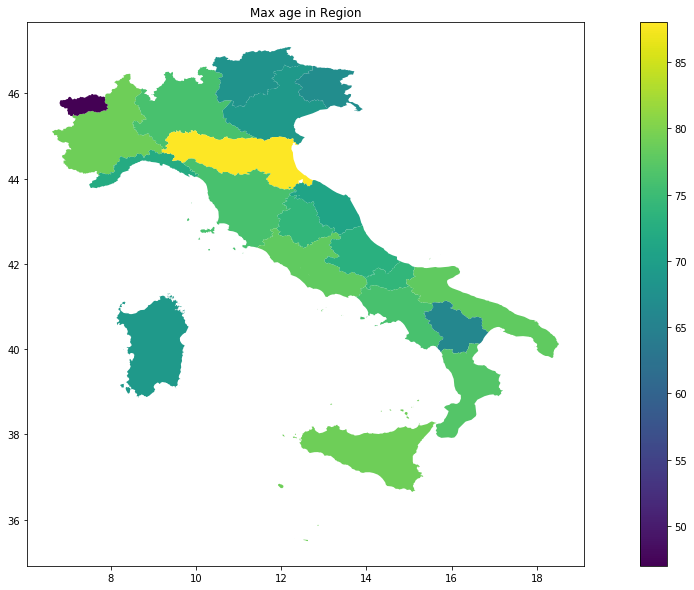

In [1000]:
#result contiene i dati degli utenti, interazione, uso esclusivo, progressivo_follow_up e REGIONE e altro
#R_tot=result.groupby(['REGIONE','User_ID'])[['User_ID']].count()
#R=result[result['Risultato_contatto_Whatsapp']==1]
#R=R.groupby(['REGIONE'])['Risultato_contatto_Whatsapp'].count()
R=result[(result['Eta']>18) & (result['Eta']<100)].copy()
R2=R.copy()
R2=R2[['User_ID','REGIONE','Eta']]
R2.drop_duplicates(keep='first', inplace=True)

R3=R2.groupby('REGIONE')['Eta'].max()
#Plot
R3=R3.reset_index()
Eta=pd.merge(df2,R3,how='left',on='REGIONE')
Eta.plot(column='Eta',legend=True)
plt.title('Max age in Region')
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(20, 10)
fig.savefig('Max_Age_In_Regions.png', dpi=200)
plt.show()

88.0

,REGIONE,Eta
0,ABRUZZO,40.443515
1,BASILICATA,41.057692
2,CALABRIA,40.512315
3,CAMPANIA,39.892486
4,EMILIA-ROMAGNA,39.696556
5,FRIULI-VENEZIA GIULIA,42.426230
6,LAZIO,41.394521
7,LIGURIA,42.109244
8,LOMBARDIA,40.275837
9,MARCHE,41.453333


# Mappa di interazione per ogni regione

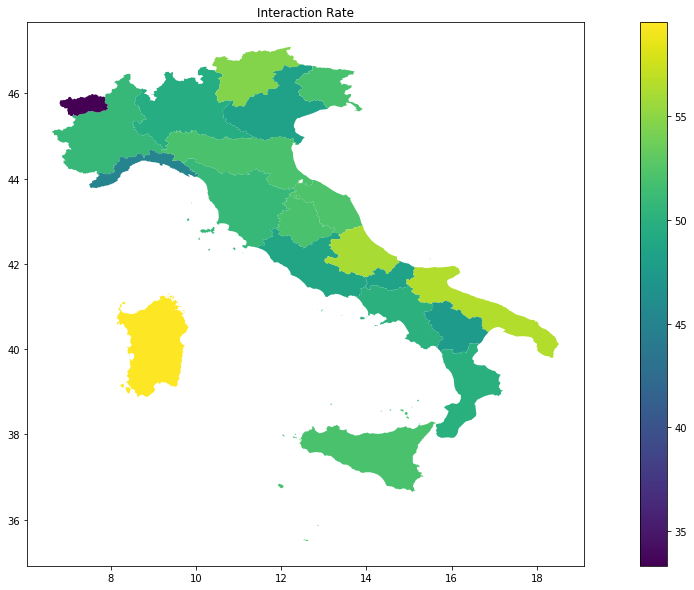

In [1003]:
Int=Ottobre.groupby('REGIONE')['Risultato_contatto_Whatsapp'].mean()
Int=Int*100
Int=pd.DataFrame(Int).reset_index()
Int=Int.rename({'Risultato_contatto_Whatsapp':'Ratio_Interaction'})
Int.rename(columns={'Risultato_contatto_Whatsapp':'Ratio_Interaction'}, inplace=True)
r=pd.merge(df2,Int,on='REGIONE',how='left')
r.plot('Ratio_Interaction',legend=True)

plt.title('Interaction Rate')
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(20, 10)
fig.savefig('Interaction Rate.png', dpi=200)
plt.show()

# Mappa di Conversione
Si basa su USO=Esclusivo

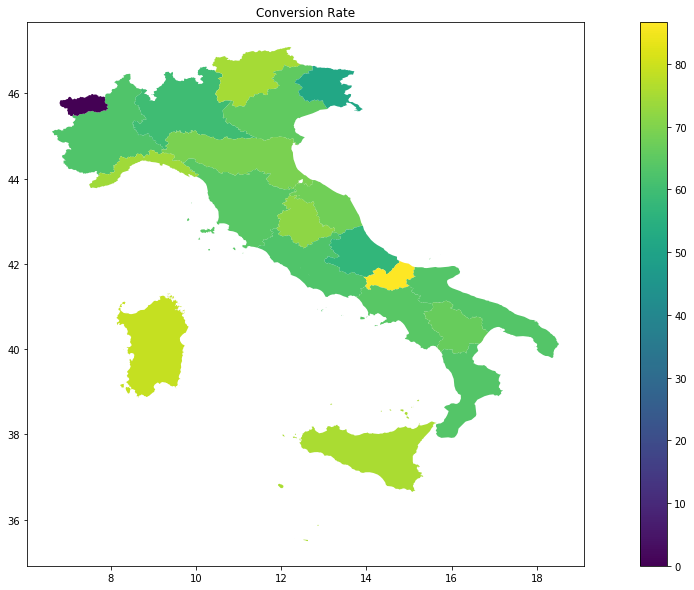

In [1146]:
#Prendo prima di tutto gli interacting users, quelli che hanno risposto al messaggio con Risultato_cont...=1
# e Utente_Convertito

Esclusivo=Ottobre[Ottobre['Tipo_di_Utilizzo']==3]
Esclusivo=Esclusivo.groupby('REGIONE').count().reset_index()
Totali=Ottobre.groupby('REGIONE').count().reset_index()
Totali=Totali[['REGIONE','Tipo_di_Utilizzo']]

Esclusivo=Esclusivo[['REGIONE','Tipo_di_Utilizzo']]

Totali.rename(columns={'Tipo_di_Utilizzo':'Totali'},inplace=True)
Esclusivo.rename(columns={'Tipo_di_Utilizzo':'Esclusivo'},inplace=True)

Conv=pd.merge(df2,Totali,on='REGIONE',how='left')
Conv=pd.merge(Conv,Esclusivo,on='REGIONE',how='left')
Conv['Ratio']=(Conv['Esclusivo']/Conv['Totali'])*100
Conv.loc[Conv['Esclusivo'].isnull(),'Ratio']=0
Conv.plot(column='Ratio',legend=True)

plt.title('Conversion Rate')
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(20, 10)
fig.savefig('Conversion Rate.png', dpi=200)
plt.show()


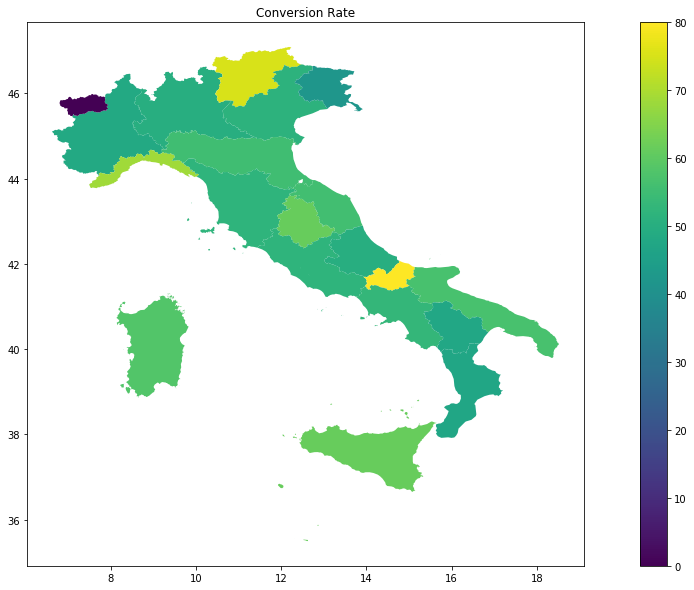

In [1147]:
#Prendo prima di tutto gli interacting users, quelli che hanno risposto al messaggio con Risultato_cont...=1
# e Utente_Convertito

Esclusivo=Ottobre[(Ottobre['Tipo_di_Utilizzo']==3)&(Ottobre['Risultato_contatto_Whatsapp']==1)]
Esclusivo=Esclusivo.groupby('REGIONE').count().reset_index()
Totali=Ottobre[Ottobre['Risultato_contatto_Whatsapp']==1]
Totali=Ottobre.groupby('REGIONE').count().reset_index()
Totali=Totali[['REGIONE','Tipo_di_Utilizzo']]

Esclusivo=Esclusivo[['REGIONE','Tipo_di_Utilizzo']]

Totali.rename(columns={'Tipo_di_Utilizzo':'Totali'},inplace=True)
Esclusivo.rename(columns={'Tipo_di_Utilizzo':'Esclusivo'},inplace=True)

Conv=pd.merge(df2,Totali,on='REGIONE',how='left')
Conv=pd.merge(Conv,Esclusivo,on='REGIONE',how='left')
Conv['Ratio']=(Conv['Esclusivo']/Conv['Totali'])*100
Conv.loc[Conv['Esclusivo'].isnull(),'Ratio']=0
Conv.plot(column='Ratio',legend=True)

plt.title('Conversion Rate')
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(20, 10)
fig.savefig('Conversion Rate.png', dpi=200)
plt.show()

In [1153]:
Ottobre[(Ottobre['Utente_Convertito']==1) & (Ottobre['Tipo_di_Utilizzo'].isnull())]

23

53.340040686694593

In [1052]:
O=Ottobre[Ottobre['Risultato_contatto_Whatsapp']==1]
O

,Progressivo_Follow_Up,User_ID,COMUNE,Genere,Data_di_nascita,Fonte_acquisto,Utente_Convertito,Tipo_di_Utilizzo,REGIONE,CAP1_x,Risultato_contatto_Whatsapp,Eta
1,2,302334,roma,M,08/09/84 00:00,ALTRO,1.0,3.0,LAZIO,148,1.0,33.0
2,2,302273,san giorgio a cremano,F,04/09/95 00:00,IQOS STORE,1.0,3.0,CAMPANIA,80046,1.0,22.0
3,2,302840,parabiago,F,04/08/70 00:00,IQOS STORE,1.0,3.0,LOMBARDIA,20015,1.0,47.0
5,3,297187,roma,F,1/18/1955 12:00:00 AM,ALTRO,1.0,2.0,LAZIO,197,1.0,62.0
6,2,311564,albinea,F,09/11/67 00:00,IQOS STORE,NaN,2.0,EMILIA-ROMAGNA,42020,1.0,50.0
7,2,311843,budrio,M,1/21/1990 12:00:00 AM,IQOS STORE,NaN,2.0,EMILIA-ROMAGNA,40054,1.0,27.0
8,2,310433,pralboino,F,12/12/87 00:00,IQOS STORE,0.0,1.0,LOMBARDIA,25020,1.0,30.0
9,2,311890,santa marinella,F,11/21/1970 12:00:00 AM,IQOS STORE,NaN,2.0,LAZIO,58,1.0,47.0
10,2,311549,san marzano di san giuseppe,M,1/31/1979 12:00:00 AM,IQOS STORE,NaN,2.0,PUGLIA,74020,1.0,38.0
11,2,309382,casalecchio di reno,F,3/23/1991 12:00:00 AM,EMBASSY,1.0,3.0,EMILIA-ROMAGNA,40033,1.0,26.0


In [ ]:
Ris_Nan=R[R['Risultato_contatto_Whatsapp'].isnull()]
Ris_Nan.groupby('REGIONE')['User_ID'].count().index

In [ ]:
Ottobre_Count['Conv_SI']=Ottobre_SI['Conv_SI']
Ottobre_Count['Conv_NO']=Ottobre_NO['Conv_NO']
Ottobre_Count['Conv_Nan']=Ottobre_Nan['Conv_Nan']

In [ ]:
Ottobre_Count['Ratio_Conv']=Ottobre_Count['Conv_SI']/(Ottobre_Count['Conv_SI']+Ottobre_Count['Conv_NO']+Ottobre_Count['Conv_Nan'])

In [ ]:
Ottobre_Count